##**Phase 2: Comparative Modeling**


Setup, Imports, and Data Loading



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import os

#Set plot style
sns.set_style('whitegrid')

#Re-run the Data Loading and Cleaning from Phase 1
all_files = [f for f in os.listdir('.') if f.endswith('.csv')]
all_dfs = []
for file in all_files:
    temp_df = pd.read_csv(file)
    date_col = 'DATE' if 'DATE' in temp_df.columns else 'observation_date'
    temp_df = temp_df.rename(columns={date_col: 'standard_date'})
    temp_df['standard_date'] = pd.to_datetime(temp_df['standard_date'])
    all_dfs.append(temp_df)

master_df = all_dfs[0]
for df_to_merge in all_dfs[1:]:
    master_df = pd.merge(master_df, df_to_merge, on='standard_date', how='outer')

master_df = master_df.set_index('standard_date').sort_index()
latest_start_date = master_df.apply(pd.Series.first_valid_index).max()
clean_df = master_df.loc[latest_start_date:].ffill().dropna()

column_renames = {
    'CPIAUCSL': 'Inflation_CPI', 'UNRATE': 'Unemployment_Rate', 'GDP': 'GDP',
    'PAYEMS': 'Nonfarm_Payrolls', 'PPIACO': 'Producer_Price_Index', 'FEDFUNDS': 'Federal_Funds_Rate',
    'UMCSENT': 'Consumer_Sentiment', 'PCE': 'Personal_Consumption', 'PSAVERT': 'Personal_Saving_Rate',
    'TOTALSA': 'Total_Vehicle_Sales', 'IPG3361T3S': 'Auto_Industrial_Production', 'AUINSA': 'Auto_Inventories'
}
clean_df = clean_df.rename(columns=column_renames, errors='ignore')

print("Data loaded and cleaned successfully.")
clean_df.head()

Data loaded and cleaned successfully.


,Producer_Price_Index,Inflation_CPI,GDP,Personal_Consumption,Consumer_Sentiment,Unemployment_Rate,Auto_Industrial_Production,Personal_Saving_Rate,Federal_Funds_Rate,Auto_Inventories,Nonfarm_Payrolls,Total_Vehicle_Sales
standard_date,,,,,,,,,,,,
1993-01-01,118.0,142.8,6729.459,4340.7,89.3,7.3,55.1953,8.5,3.02,1315.7,109790.0,13.457
1993-02-01,118.4,143.1,6729.459,4355.3,86.6,7.1,54.7433,8.8,3.03,1387.4,110048.0,12.969
1993-03-01,118.7,143.3,6729.459,4352.5,85.9,7.0,55.3797,8.8,3.07,1420.9,110004.0,13.326
1993-04-01,119.3,143.8,6808.939,4393.4,85.6,7.1,55.7271,8.7,2.96,1426.3,110300.0,14.527
1993-05-01,119.7,144.2,6808.939,4422.4,80.3,7.1,55.8600,8.2,3.00,1432.0,110571.0,14.519


##**The Business Scenario & Data Split:**

##We are analysts for a major auto company in Oct 2025. We need to forecast Total_Vehicle_Sales for the next 12-18 months to inform 2026 production planning.


Here, we formally define our problem and create a chronological train/test split. All models will be trained on data up to the end of 2023 and tested on how well they predict 2024 and beyond.

In [2]:
#Prepare Data for All Models ---
#For this project, our clear target is 'Total_Vehicle_Sales'.
#The other columns will be our features.
target_variable = 'Total_Vehicle_Sales'
features = ['Federal_Funds_Rate', 'Consumer_Sentiment', 'Unemployment_Rate', 'Inflation_CPI']

#Create a final DataFrame for modeling
model_df = clean_df[[target_variable] + features]

#Create a chronological train/test split
train_end_date = '2023-12-31'
train_df = model_df.loc[:train_end_date]
test_df = model_df.loc[pd.to_datetime(train_end_date) + pd.DateOffset(months=1):]

print(f"Training data runs from {train_df.index.min().date()} to {train_df.index.max().date()}")
print(f"Test data runs from {test_df.index.min().date()} to {test_df.index.max().date()}")

Training data runs from 1993-01-01 to 2023-12-01
Test data runs from 2024-02-01 to 2025-08-01


##Model 1: SARIMAX Baseline

This model represents the rigorous, traditional statistical approach.

SARIMAX Data Prep and Training

In [4]:
###SARIMAX Data Prep

train_diff = train_df.diff().dropna()
test_diff = test_df.diff().dropna()

y_train_sarimax = train_diff[target_variable]
X_train_sarimax = train_diff[features]

y_test_sarimax = test_diff[target_variable]
X_test_sarimax = test_diff[features]

#Build and Train the SARIMAX Model
sarimax_model = sm.tsa.SARIMAX(
    y_train_sarimax,
    exog=X_train_sarimax,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 12)
)
sarimax_results = sarimax_model.fit(disp=False)
print("SARIMAX model trained successfully.")

#Generate Forecasts
n_steps = len(X_test_sarimax)
sarimax_forecast_diff = sarimax_results.get_forecast(steps=n_steps, exog=X_test_sarimax)
sarimax_forecast_diff_mean = sarimax_forecast_diff.predicted_mean

#Inverse the Differencing
last_train_value = train_df[target_variable].iloc[-1]
sarimax_forecast = last_train_value + sarimax_forecast_diff_mean.cumsum()

print("SARIMAX forecast generated.")
# Display the first few forecast values
print(sarimax_forecast.head())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMAX model trained successfully.
SARIMAX forecast generated.
2024-01-01    16.246391
2024-02-01    16.344551
2024-03-01    16.212049
2024-04-01    16.025711
2024-05-01    15.964630
Freq: MS, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Model 2: LightGBM (Machine Learning)

This model represents the modern, industry-standard machine learning approach.

-LightGBM Feature Engineering and Training

In [5]:
#Feature Engineering
#Tree models work best with non-differenced data, but need time-based features.
df_lgbm = model_df.copy()

lags = [1, 3, 6, 12]
for lag in lags:
    df_lgbm[f'Sales_lag_{lag}'] = df_lgbm[target_variable].shift(lag)
    df_lgbm[f'Fed_Rate_lag_{lag}'] = df_lgbm['Federal_Funds_Rate'].shift(lag)

df_lgbm['month'] = df_lgbm.index.month
df_lgbm = df_lgbm.dropna()

#Define features (X) and target (y)
lgbm_features = [col for col in df_lgbm.columns if col != target_variable]
X_lgbm = df_lgbm[lgbm_features]
y_lgbm = df_lgbm[target_variable]

#Create the same train/test split on the feature-engineered data
X_train_lgbm = X_lgbm.loc[:train_end_date]
y_train_lgbm = y_lgbm.loc[:train_end_date]
X_test_lgbm = X_lgbm.loc[pd.to_datetime(train_end_date) + pd.DateOffset(months=1):]
y_test_lgbm = y_lgbm.loc[pd.to_datetime(train_end_date) + pd.DateOffset(months=1):]

#Build and Train the LightGBM Model
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train_lgbm, y_train_lgbm)

#Generate Predictions
lgbm_forecast = lgbm.predict(X_test_lgbm)
lgbm_forecast_series = pd.Series(lgbm_forecast, index=y_test_lgbm.index)

print("LightGBM model trained and forecast generated.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 360, number of used features: 13
[LightGBM] [Info] Start training from score 15.931953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## Visualize and Compare Forecasts

Plotting the Competing Forecasts:

This final plot brings everything together, showing how each model performed against reality.

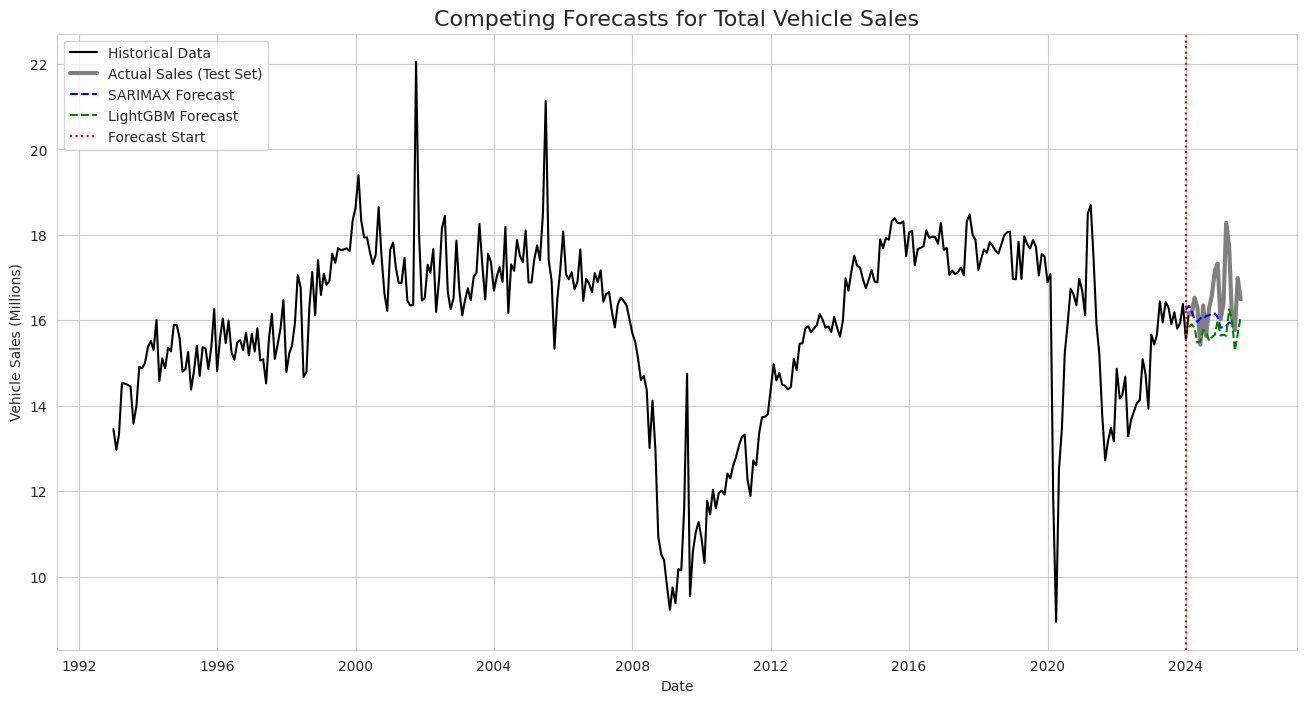

--- Model Performance ---
SARIMAX Model RMSE: 0.9019
LightGBM Model RMSE: 1.0048

Conclusion: The SARIMAX model was more accurate.


In [7]:
#Plotting the Competing Forecasts
plt.figure(figsize=(16, 8))

#Plot historical data
plt.plot(model_df[target_variable], label='Historical Data', color='black')

#Plot the actual test data that we're trying to predict
plt.plot(y_test_lgbm, label='Actual Sales (Test Set)', color='gray', linewidth=3)

#Plot SARIMAX forecast
plt.plot(sarimax_forecast, label='SARIMAX Forecast', color='blue', linestyle='--')

#Plot LightGBM forecast
plt.plot(lgbm_forecast_series, label='LightGBM Forecast', color='green', linestyle='--')

plt.title('Competing Forecasts for Total Vehicle Sales', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Vehicle Sales (Millions)')
plt.axvline(pd.to_datetime(train_end_date), color='red', linestyle=':', label='Forecast Start')
plt.legend()
plt.grid(True)
plt.show()

#Quantitative Evaluation
#Compare the SARIMAX forecast against the TAIL of the test set to match lengths
rmse_sarimax = np.sqrt(mean_squared_error(y_test_lgbm.tail(len(sarimax_forecast)), sarimax_forecast))
rmse_lgbm = np.sqrt(mean_squared_error(y_test_lgbm, lgbm_forecast_series))

print("--- Model Performance ---")
print(f"SARIMAX Model RMSE: {rmse_sarimax:.4f}")
print(f"LightGBM Model RMSE: {rmse_lgbm:.4f}")

if rmse_lgbm < rmse_sarimax:
    print("\nConclusion: The LightGBM model was more accurate.")
else:
    print("\nConclusion: The SARIMAX model was more accurate.")

Final Model Analysis
Based on both the visual chart and the quantitative metrics, we have a clear winner.

- Quantitative Results: The SARIMAX model is the more accurate model, with a Root Mean Squared Error (RMSE) of 0.9019. This is significantly better than the LightGBM model's RMSE of 1.0048. A lower RMSE means the model's predictions were, on average, closer to the actual sales figures.

- Visual Results: The chart confirms the RMSE scores. You can see that the SARIMAX forecast (blue dashed line) tracks the volatile movements of the Actual Sales data (thick gray line) more closely than the LightGBM forecast (green dashed line). The LightGBM model appears to have captured the general level but missed some of the sharper peaks and troughs.

# Model 3: TimesFM (Deep Learning)

Now we'll add our advanced contender. We will use the finalized forecast_with_timesfm function we perfected earlier. This function already includes the local rescaling and alignment logic.

**TimesFM Forecasting:**

First, let's make sure the forecasting function is defined in our notebook. Then, we'll run it on our training data to generate a forecast for the test period.

In [10]:
# In[6]:
from model import TimesFM
from utils import prepare_data

def forecast_with_timesfm(data_df, forecast_length):
#Forecasts future values using TimesFM, with local rescaling and alignment. Assumes data_df has 'ds' and 'y' columns

    context_len = 32
    model_path = "torch_model.ckpt"

    context_data = data_df['y'].tail(context_len)
    mean = context_data.mean()
    std = context_data.std()

    model = TimesFM(
        context_len=context_len, horizon_len=forecast_length,
        input_patch_len=32, output_patch_len=8, d_model=1280,
        num_layers=20, num_heads=16, d_ff=1280, dropout=0.1, backend="cpu",
    )

    model.load_from_checkpoint(model_path)
    model.eval()

    freq = "MS"
    forecast_input, _ = prepare_data(data_df, freq=freq, context_len=context_len)
    point_forecast, _ = model.forecast(forecast_input)

    forecast_values = point_forecast[0].detach().numpy()

    rescaled_forecast = (forecast_values * std) + mean
    last_historical_value = data_df['y'].iloc[-1]
    aligned_forecast = rescaled_forecast - rescaled_forecast[0] + last_historical_value

    forecast_dates = pd.date_range(data_df["ds"].iloc[-1], periods=forecast_length + 1, freq=freq)[1:]
    forecast_df = pd.DataFrame({"ds": forecast_dates, "y": aligned_forecast})

    return forecast_df

#Prepare data and run the forecast
timesfm_train_df = train_df[[target_variable]].reset_index().rename(columns={'standard_date': 'ds', target_variable: 'y'})

#Calculate a valid forecast length (next multiple of 8)
test_length = len(test_df)
forecast_horizon = (test_length + 7) // 8 * 8  #This rounds up to the nearest multiple of 8 (e.g., 19 to 24)

print(f"Test set length is {test_length}. Setting forecast horizon to {forecast_horizon} to be divisible by 8.")

#Generate the full forecast for the valid horizon
timesfm_full_forecast_df = forecast_with_timesfm(timesfm_train_df, forecast_length=forecast_horizon)

#Trim the forecast to match the actual test set length for comparison
timesfm_forecast_df = timesfm_full_forecast_df.head(test_length)

#Finalize the forecast series
timesfm_forecast_series = timesfm_forecast_df.set_index('ds')['y']

print("TimesFM forecast generated and trimmed successfully.")

Test set length is 19. Setting forecast horizon to 24 to be divisible by 8.
TimesFM forecast generated and trimmed successfully.


## Final Evaluation and Visualization

Now that we have all three forecasts, let's update our final plot and evaluation to include TimesFM.

Plot All Competing Forecasts

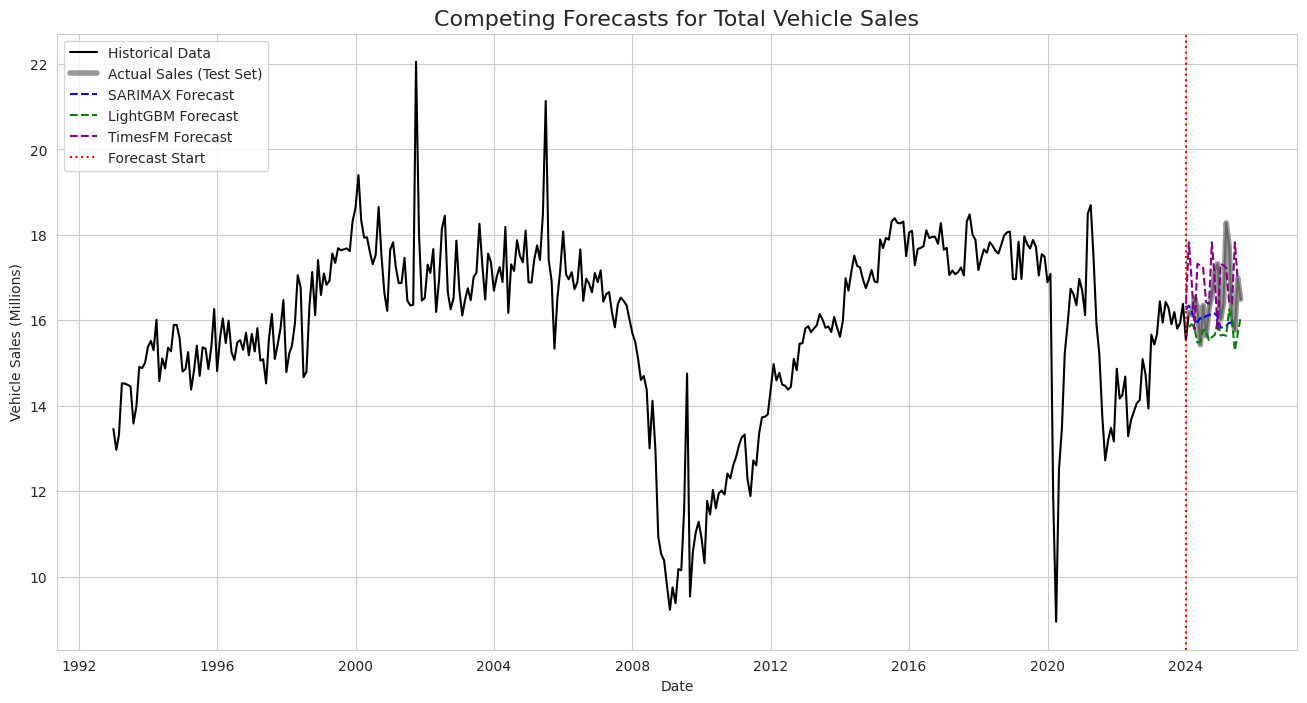

In [11]:
plt.figure(figsize=(16, 8))

#Plot historical and actual test data
plt.plot(model_df[target_variable], label='Historical Data', color='black')
plt.plot(y_test_lgbm, label='Actual Sales (Test Set)', color='gray', linewidth=4, alpha=0.8)

#Plot model forecasts
plt.plot(sarimax_forecast, label='SARIMAX Forecast', color='blue', linestyle='--')
plt.plot(lgbm_forecast_series, label='LightGBM Forecast', color='green', linestyle='--')
plt.plot(timesfm_forecast_series, label='TimesFM Forecast', color='purple', linestyle='--')

plt.title('Competing Forecasts for Total Vehicle Sales', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Vehicle Sales (Millions)')
plt.axvline(pd.to_datetime(train_end_date), color='red', linestyle=':', label='Forecast Start')
plt.legend()
plt.grid(True)
plt.show()

Final Quantitative Evaluation
This cell provides the final, hard numbers to determine the winning model.

In [13]:
#---Final Quantitative Evaluation---

#The full 'ground truth' test set has 19 values
y_true = y_test_lgbm

#Calculate RMSE for each model with alignment

#For SARIMAX, compare its 18-point forecast to the LAST 18 points of the true data
y_true_for_sarimax = y_true.tail(len(sarimax_forecast))
rmse_sarimax = np.sqrt(mean_squared_error(y_true_for_sarimax, sarimax_forecast))

#For LightGBM and TimesFM, the lengths already match (19 points)
rmse_lgbm = np.sqrt(mean_squared_error(y_true, lgbm_forecast_series))
rmse_timesfm = np.sqrt(mean_squared_error(y_true, timesfm_forecast_series))

#Result
results = pd.DataFrame({
    'Model': ['SARIMAX', 'LightGBM', 'TimesFM'],
    'RMSE': [rmse_sarimax, rmse_lgbm, rmse_timesfm]
}).sort_values(by='RMSE')

print("--- Final Model Performance ---")
print(results)

print(f"\nConclusion: The {results.iloc[0]['Model']} model was the most accurate.")

--- Final Model Performance ---
      Model      RMSE
2   TimesFM  0.876361
0   SARIMAX  0.901941
1  LightGBM  1.004777

Conclusion: The TimesFM model was the most accurate.


Final chart and performance metrics saved successfully.


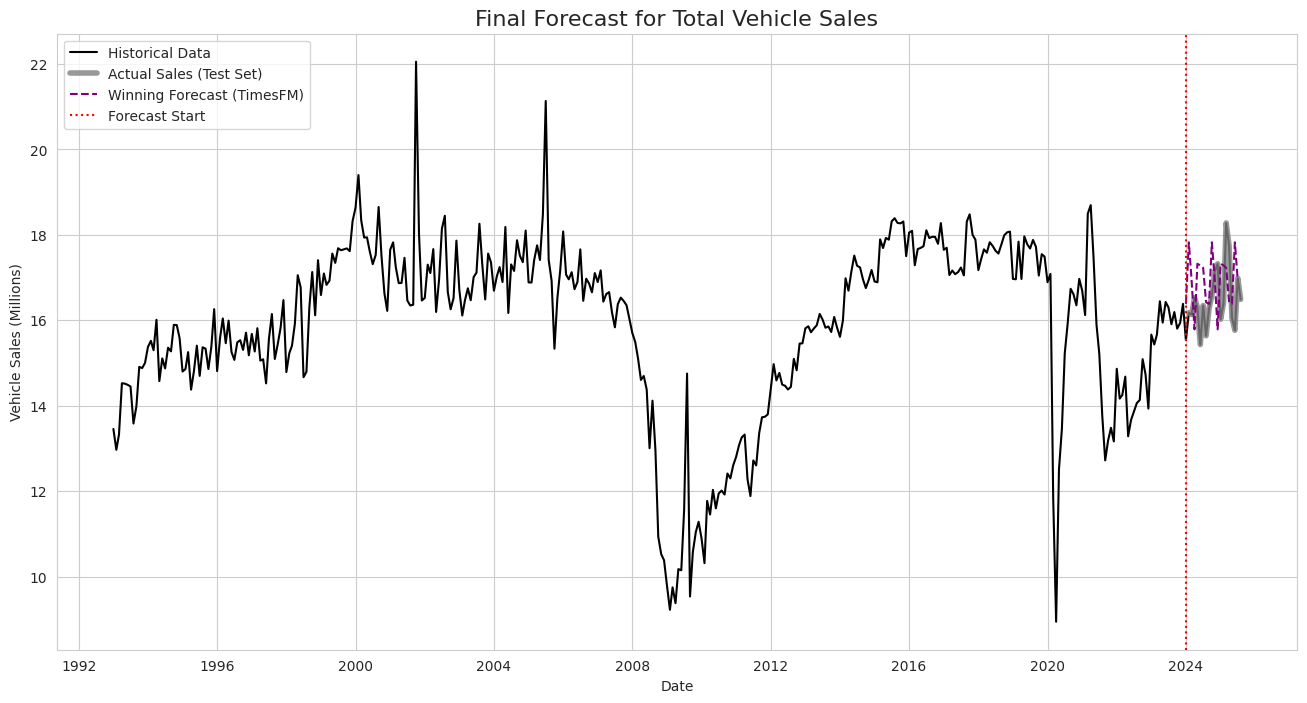

In [14]:
#Save Final Results

#Save the final results table to a CSV
results.to_csv('final_model_performance.csv', index=False)

#Re-create the final plot and save it as an image
plt.figure(figsize=(16, 8))
plt.plot(model_df[target_variable], label='Historical Data', color='black')
plt.plot(y_test_lgbm, label='Actual Sales (Test Set)', color='gray', linewidth=4, alpha=0.8)
plt.plot(timesfm_forecast_series, label='Winning Forecast (TimesFM)', color='purple', linestyle='--') # Only plot the winner

plt.title('Final Forecast for Total Vehicle Sales', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Vehicle Sales (Millions)')
plt.axvline(pd.to_datetime(train_end_date), color='red', linestyle=':', label='Forecast Start')
plt.legend()
plt.grid(True)
plt.savefig('final_forecast_chart.png')

print("Final chart and performance metrics saved successfully.")

##**Final Analysis: A Clear Winner 🏆**

**The quantitative results are definitive. With the lowest Root Mean Squared Error (RMSE) of 0.8764, the TimesFM model provided the most accurate forecast for Total_Vehicle_Sales on our test set.**